# Data Preprocessing Analysis

Comprehensive analysis of the cleaned feature set to identify preprocessing improvements.

**Objectives:**
1. Analyze categorical features (unique counts, cardinality)
2. Investigate APACHE -1.0 values and missing data patterns
3. Check for outliers in numeric features
4. Identify feature engineering opportunities
5. Document all findings for preprocessing pipeline improvements

## Setup

In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.precision', 4)

plt.style.use('default')
sns.set_palette('husl')

print("Setup complete!")

Setup complete!


## Load Data

In [2]:
# Connect and load data
db_path = Path("../../data/duckdb/fedlearn.duckdb")
conn = duckdb.connect(str(db_path), read_only=True)
df = conn.execute("SELECT * FROM v_features_icu_stay_clean").df()
conn.close()

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (199646, 77)

First few rows:


,patientunitstayid,los_days,prolonged_stay,age_numeric,gender,ethnicity,admissionheight,admissionweight,unittype,unitadmitsource,unitvisitnumber,hospitaladmitsource,apacheadmissiondx,admissiondx_category,numbedscategory,teachingstatus,hospital_region,apache_intubated,apache_vent,apache_dialysis,apache_urine_24h,apache_wbc,apache_temp,apache_rr,apache_sodium,apache_hr,apache_meanbp,apache_ph,apache_hct,apache_creatinine,apache_albumin,apache_pao2,apache_pco2,apache_bun,apache_glucose,apache_bilirubin,apache_gcs_eyes,apache_gcs_verbal,apache_gcs_motor,apache_fio2,is_missing_gcs_eyes,is_missing_gcs_verbal,is_missing_gcs_motor,apache_bedcount,apache_admitsource_code,apache_diabetes,apache_aids,apache_hepaticfailure,apache_lymphoma,apache_metastaticcancer,apache_leukemia,apache_immunosuppression,apache_cirrhosis,apache_electivesurgery,apache_readmit,apache_ventday1,apache_oobventday1,apache_oobintubday1,avg_hr_24h,min_hr_24h,max_hr_24h,avg_rr_24h,min_rr_24h,max_rr_24h,avg_sao2_24h,min_sao2_24h,max_sao2_24h,creatinine_mean_24h,creatinine_max_24h,wbc_mean_24h,glucose_mean_24h,vent_started_24h,ever_vented,pressor_norepi_24h,pressor_epi_24h,pressor_vaso_24h,sedative_propofol_24h
0,2669728,5.8208,1,65,male,Other/Unknown,152.4,53.5,Med-Surg ICU,Floor,1,None,"Sepsis, pulmonary",sepsis,250 - 499,False,West,0,1,0,-1.0000,13.8,36.8,29.0,133.0,119.0,163.0,7.315,33.2,1.21,-1.0,107.0,38.9,25.0,138.0,-1.0,4.0,4.0,6.0,100.0,0,0,0,84,4,0,0,0,0,0,0,0,0,<NA>,0,1,1,1,80.8727,63,117,13.7091,12,29,99.7673,96,100,1.105,1.21,12.05,131.0000,1,1,1,1,0,1
1,2676582,0.6993,0,84,female,Caucasian,167.6,74.8,Med-Surg ICU,Emergency Department,1,None,Cardiac arrest (with or without respiratory ar...,respiratory,250 - 499,False,None,0,1,0,-1.0000,23.3,21.8,33.0,143.0,155.0,197.0,-1.000,31.5,1.71,-1.0,-1.0,-1.0,21.0,41.0,-1.0,2.0,1.0,3.0,-1.0,0,0,0,58,8,1,0,0,0,0,0,0,0,<NA>,0,1,1,1,127.8861,0,155,19.8861,0,32,64.8533,0,100,1.680,1.71,23.15,88.4286,1,1,0,0,0,0
2,2684457,3.6653,1,71,male,Caucasian,182.9,144.2,Med-Surg ICU,Emergency Department,1,None,"Neurologic medical, other",other,250 - 499,False,West,1,1,0,2558.2176,17.9,36.6,8.0,133.0,58.0,58.0,7.425,37.4,0.78,3.2,62.0,37.9,22.0,213.0,0.9,4.0,5.0,6.0,60.0,0,0,0,84,8,1,0,0,0,0,0,0,0,<NA>,0,1,1,1,64.3798,58,84,16.4425,0,22,94.8873,90,100,1.010,1.01,10.10,167.7600,1,1,1,1,0,1
3,2685444,11.1375,1,50,male,Caucasian,160.0,79.1,Med-Surg ICU,Emergency Department,1,Emergency Department,Cardiac arrest (with or without respiratory ar...,respiratory,250 - 499,False,West,0,1,0,-1.0000,14.5,31.9,36.0,138.0,48.0,159.0,-1.000,41.8,1.84,3.1,-1.0,-1.0,25.0,73.0,0.7,1.0,1.0,1.0,-1.0,0,0,0,49,8,0,0,0,0,0,0,0,0,<NA>,0,1,1,1,63.4321,50,91,14.6376,12,35,99.0430,82,100,1.670,1.84,14.50,109.0000,1,1,0,0,0,1
4,2690037,2.8104,0,78,female,Caucasian,170.2,82.0,Med-Surg ICU,Emergency Department,1,Emergency Department,Emphysema/bronchitis,other,250 - 499,False,West,0,0,0,-1.0000,7.1,37.1,4.0,143.0,49.0,45.0,7.382,28.9,1.04,-1.0,112.0,51.9,23.0,162.0,-1.0,3.0,1.0,5.0,70.0,0,0,0,84,8,1,0,0,0,0,0,0,0,<NA>,0,0,0,0,62.0208,49,80,15.9479,0,28,97.4514,87,100,1.040,1.04,7.10,147.8571,1,1,0,0,0,1


## Current Feature Classification

Review how features are currently classified in Jim's code.

In [3]:
# Current classification from centralized_logreg.py
current_categorical = [
    "gender",
    "ethnicity",
    "unittype",
    "unitadmitsource",
    "hospitaladmitsource",
    "admissiondx_category",
    "numbedscategory",
    "teachingstatus",
    "hospital_region",
]

# Features excluded from modeling
excluded_features = ["patientunitstayid", "los_days", "prolonged_stay", "apacheadmissiondx"]

# All features used in modeling
all_features = [c for c in df.columns if c not in excluded_features]
current_numeric = [c for c in all_features if c not in current_categorical]

print(f"Total features in dataset: {len(df.columns)}")
print(f"Excluded from modeling: {len(excluded_features)}")
print(f"Features used in modeling: {len(all_features)}")
print(f"  - Current categorical: {len(current_categorical)}")
print(f"  - Current numeric: {len(current_numeric)}")
print(f"\nCurrent categorical features:")
for feat in current_categorical:
    print(f"  - {feat}")

Total features in dataset: 77
Excluded from modeling: 4
Features used in modeling: 73
  - Current categorical: 9
  - Current numeric: 64

Current categorical features:
  - gender
  - ethnicity
  - unittype
  - unitadmitsource
  - hospitaladmitsource
  - admissiondx_category
  - numbedscategory
  - teachingstatus
  - hospital_region


## 1. Categorical Features Analysis

In [4]:
# Analyze each categorical feature
print("=" * 80)
print("CATEGORICAL FEATURES ANALYSIS")
print("=" * 80)

cat_analysis = []

for feat in current_categorical:
    unique_count = df[feat].nunique()
    null_count = df[feat].isnull().sum()
    null_pct = (null_count / len(df)) * 100
    
    cat_analysis.append({
        'feature': feat,
        'unique_values': unique_count,
        'null_count': null_count,
        'null_pct': null_pct,
        'data_type': df[feat].dtype
    })
    
    print(f"\n{feat}:")
    print(f"  Unique values: {unique_count}")
    print(f"  Null values: {null_count} ({null_pct:.2f}%)")
    print(f"  Data type: {df[feat].dtype}")
    print(f"  Value counts:")
    print(df[feat].value_counts().head(10).to_string())
    
    # Check for high cardinality
    if unique_count > 20:
        print(f"  ⚠️  HIGH CARDINALITY: {unique_count} unique values")

cat_df = pd.DataFrame(cat_analysis)
print("\n" + "=" * 80)
print("SUMMARY:")
print(cat_df.to_string(index=False))

CATEGORICAL FEATURES ANALYSIS

gender:
  Unique values: 4
  Null values: 0 (0.00%)
  Data type: object
  Value counts:
gender
male       107715
female      91758
unknown       165
other           8

ethnicity:
  Unique values: 6
  Null values: 2283 (1.14%)
  Data type: object
  Value counts:
ethnicity
Caucasian           154269
African American     21223
Other/Unknown         9488
Hispanic              7443
Asian                 3244
Native American       1696

unittype:
  Unique values: 8
  Null values: 0 (0.00%)
  Data type: object
  Value counts:
unittype
Med-Surg ICU    112519
MICU             17343
CCU-CTICU        15227
Neuro ICU        14417
Cardiac ICU      12426
SICU             11989
CSICU             9576
CTICU             6149

unitadmitsource:
  Unique values: 15
  Null values: 962 (0.48%)
  Data type: object
  Value counts:
unitadmitsource
Emergency Department    89344
Floor                   24267
Operating Room          24249
ICU to SDU              13484
Direct Admit  

## 2. Numeric Features - Check for Miscategorized Features

In [5]:
# Check if any numeric features should be categorical
print("=" * 80)
print("CHECKING FOR MISCATEGORIZED FEATURES")
print("=" * 80)

potential_categorical = []

for feat in current_numeric:
    unique_count = df[feat].nunique()
    
    # Features with very few unique values might be categorical
    if unique_count <= 10 and not feat.startswith('is_missing_'):
        potential_categorical.append({
            'feature': feat,
            'unique_values': unique_count,
            'values': sorted(df[feat].dropna().unique()[:20])
        })

if potential_categorical:
    print("\nFeatures that might be categorical (≤10 unique values):")
    for item in potential_categorical:
        print(f"\n{item['feature']}:")
        print(f"  Unique values: {item['unique_values']}")
        print(f"  Values: {item['values']}")
        print(f"  Value counts:")
        print(df[item['feature']].value_counts().to_string())
else:
    print("\nNo potential miscategorized features found.")

CHECKING FOR MISCATEGORIZED FEATURES

Features that might be categorical (≤10 unique values):

apache_intubated:
  Unique values: 2
  Values: [np.int16(0), np.int16(1)]
  Value counts:
apache_intubated
0    145216
1     25386

apache_vent:
  Unique values: 2
  Values: [np.int16(0), np.int16(1)]
  Value counts:
apache_vent
0    129266
1     41336

apache_dialysis:
  Unique values: 2
  Values: [np.int16(0), np.int16(1)]
  Value counts:
apache_dialysis
0    164298
1      6304

apache_gcs_eyes:
  Unique values: 5
  Values: [np.float64(-1.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0)]
  Value counts:
apache_gcs_eyes
 4.0    118353
 3.0     24473
 1.0     14409
 2.0      8266
-1.0      5101

apache_gcs_verbal:
  Unique values: 6
  Values: [np.float64(-1.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0)]
  Value counts:
apache_gcs_verbal
 5.0    105464
 1.0     29579
 4.0     21176
 3.0      5578
-1.0      5101
 2.0      3704

apa

## 3. APACHE -1.0 Values Investigation

Check if -1.0 values in APACHE features represent missing data.

In [6]:
# Find APACHE numeric features
apache_numeric = [c for c in current_numeric if c.startswith('apache_') and not c.startswith('is_missing_')]

print("=" * 80)
print("APACHE FEATURES: -1.0 VALUE ANALYSIS")
print("=" * 80)

apache_analysis = []

for feat in apache_numeric:
    # Count -1.0 values
    neg_one_count = (df[feat] == -1.0).sum()
    neg_one_pct = (neg_one_count / len(df)) * 100
    
    # Count actual nulls
    null_count = df[feat].isnull().sum()
    null_pct = (null_count / len(df)) * 100
    
    # Get min/max excluding -1.0
    non_neg_one = df[feat][df[feat] != -1.0]
    min_val = non_neg_one.min() if len(non_neg_one) > 0 else None
    max_val = non_neg_one.max() if len(non_neg_one) > 0 else None
    
    apache_analysis.append({
        'feature': feat,
        'neg_one_count': neg_one_count,
        'neg_one_pct': neg_one_pct,
        'null_count': null_count,
        'null_pct': null_pct,
        'min_excl_neg1': min_val,
        'max_excl_neg1': max_val
    })

apache_df = pd.DataFrame(apache_analysis)
apache_df = apache_df.sort_values('neg_one_pct', ascending=False)

print("\nFeatures with -1.0 values:")
print(apache_df[apache_df['neg_one_count'] > 0].to_string(index=False))

# Summary
features_with_neg_one = (apache_df['neg_one_count'] > 0).sum()
print(f"\n📊 SUMMARY:")
print(f"  Total APACHE numeric features: {len(apache_numeric)}")
print(f"  Features with -1.0 values: {features_with_neg_one}")
print(f"\n⚠️  ACTION NEEDED: Convert -1.0 values to NaN for proper imputation")

APACHE FEATURES: -1.0 VALUE ANALYSIS

Features with -1.0 values:
                feature  neg_one_count  neg_one_pct  null_count  null_pct  min_excl_neg1  max_excl_neg1
            apache_pao2         131545      65.8891       29044   14.5477         9.0000       636.0000
              apache_ph         131545      65.8891       29044   14.5477         6.5310         7.8100
            apache_fio2         131545      65.8891       29044   14.5477        21.0000       100.0000
            apache_pco2         131545      65.8891       29044   14.5477         6.5000       147.3000
       apache_bilirubin         109908      55.0514       29044   14.5477         0.1000        60.2000
         apache_albumin         103698      51.9409       29044   14.5477         1.0000         7.4000
       apache_urine_24h          86565      43.3592       29044   14.5477    -11245.5648    269323.7472
             apache_wbc          43022      21.5491       29044   14.5477         0.0100       198.1000

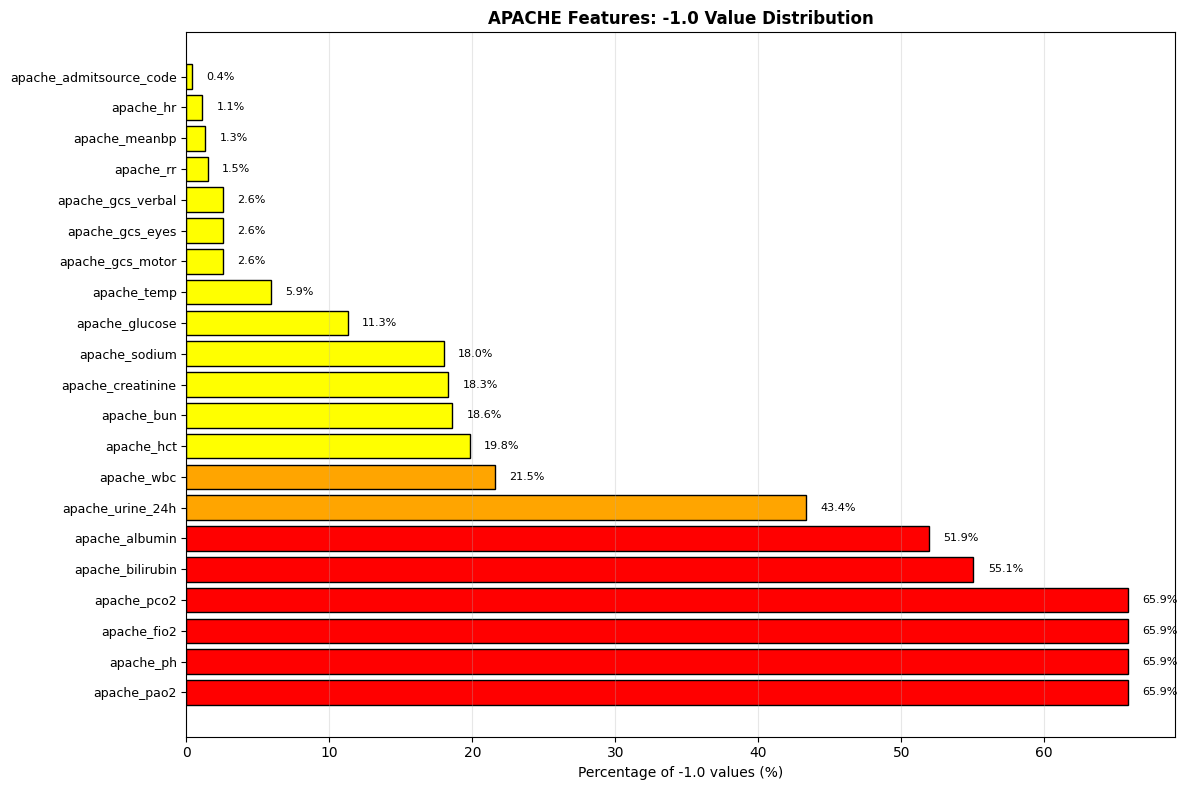

In [7]:
# Visualize the extent of -1.0 values
features_with_neg_one_vals = apache_df[apache_df['neg_one_count'] > 0].copy()

if len(features_with_neg_one_vals) > 0:
    fig, ax = plt.subplots(figsize=(12, max(8, len(features_with_neg_one_vals) * 0.3)))
    
    y_pos = range(len(features_with_neg_one_vals))
    colors = ['red' if x > 50 else 'orange' if x > 20 else 'yellow' 
              for x in features_with_neg_one_vals['neg_one_pct']]
    
    ax.barh(y_pos, features_with_neg_one_vals['neg_one_pct'], color=colors, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features_with_neg_one_vals['feature'], fontsize=9)
    ax.set_xlabel('Percentage of -1.0 values (%)')
    ax.set_title('APACHE Features: -1.0 Value Distribution', fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add percentage labels
    for i, (idx, row) in enumerate(features_with_neg_one_vals.iterrows()):
        ax.text(row['neg_one_pct'] + 1, i, f"{row['neg_one_pct']:.1f}%", va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

## 4. Outlier Detection in Numeric Features

In [8]:
# Analyze distributions and outliers for key numeric features
key_numeric = [
    'age_numeric', 'admissionheight', 'admissionweight',
    'avg_hr_24h', 'avg_rr_24h', 'avg_sao2_24h',
    'creatinine_mean_24h', 'wbc_mean_24h', 'glucose_mean_24h'
]

print("=" * 80)
print("OUTLIER ANALYSIS (IQR Method)")
print("=" * 80)

outlier_analysis = []

for feat in key_numeric:
    if feat not in df.columns:
        continue
        
    data = df[feat].dropna()
    
    # Calculate IQR
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(data)) * 100
    
    outlier_analysis.append({
        'feature': feat,
        'mean': data.mean(),
        'std': data.std(),
        'min': data.min(),
        'Q1': Q1,
        'median': data.median(),
        'Q3': Q3,
        'max': data.max(),
        'outlier_count': outlier_count,
        'outlier_pct': outlier_pct,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    })
    
    print(f"\n{feat}:")
    print(f"  Range: [{data.min():.2f}, {data.max():.2f}]")
    print(f"  Mean ± Std: {data.mean():.2f} ± {data.std():.2f}")
    print(f"  IQR bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  Outliers: {outlier_count:,} ({outlier_pct:.2f}%)")
    
    if outlier_pct > 5:
        print(f"  ⚠️  HIGH OUTLIER RATE: Consider RobustScaler")

outlier_df = pd.DataFrame(outlier_analysis)
print("\n" + "=" * 80)
print("OUTLIER SUMMARY:")
print(outlier_df[['feature', 'outlier_count', 'outlier_pct']].to_string(index=False))

OUTLIER ANALYSIS (IQR Method)

age_numeric:
  Range: [0.00, 90.00]
  Mean ± Std: 63.08 ± 17.18
  IQR bounds: [18.50, 110.50]
  Outliers: 1,055 (0.53%)

admissionheight:
  Range: [0.00, 612.60]
  Mean ± Std: 169.24 ± 13.70
  IQR bounds: [139.55, 200.75]
  Outliers: 1,464 (0.75%)

admissionweight:
  Range: [0.00, 953.00]
  Mean ± Std: 83.93 ± 27.09
  IQR bounds: [19.75, 143.35]
  Outliers: 5,386 (2.93%)

avg_hr_24h:
  Range: [0.00, 186.31]
  Mean ± Std: 84.39 ± 16.58
  IQR bounds: [38.36, 129.14]
  Outliers: 1,638 (0.86%)

avg_rr_24h:
  Range: [0.00, 129.67]
  Mean ± Std: 19.54 ± 5.22
  IQR bounds: [7.47, 30.77]
  Outliers: 5,561 (3.16%)

avg_sao2_24h:
  Range: [0.00, 100.00]
  Mean ± Std: 96.52 ± 3.36
  IQR bounds: [90.91, 102.82]
  Outliers: 4,100 (2.18%)

creatinine_mean_24h:
  Range: [0.10, 355.65]
  Mean ± Std: 2.54 ± 8.65
  IQR bounds: [-0.48, 2.74]
  Outliers: 20,770 (12.25%)
  ⚠️  HIGH OUTLIER RATE: Consider RobustScaler

wbc_mean_24h:
  Range: [0.00, 1147193.00]
  Mean ± Std: 37

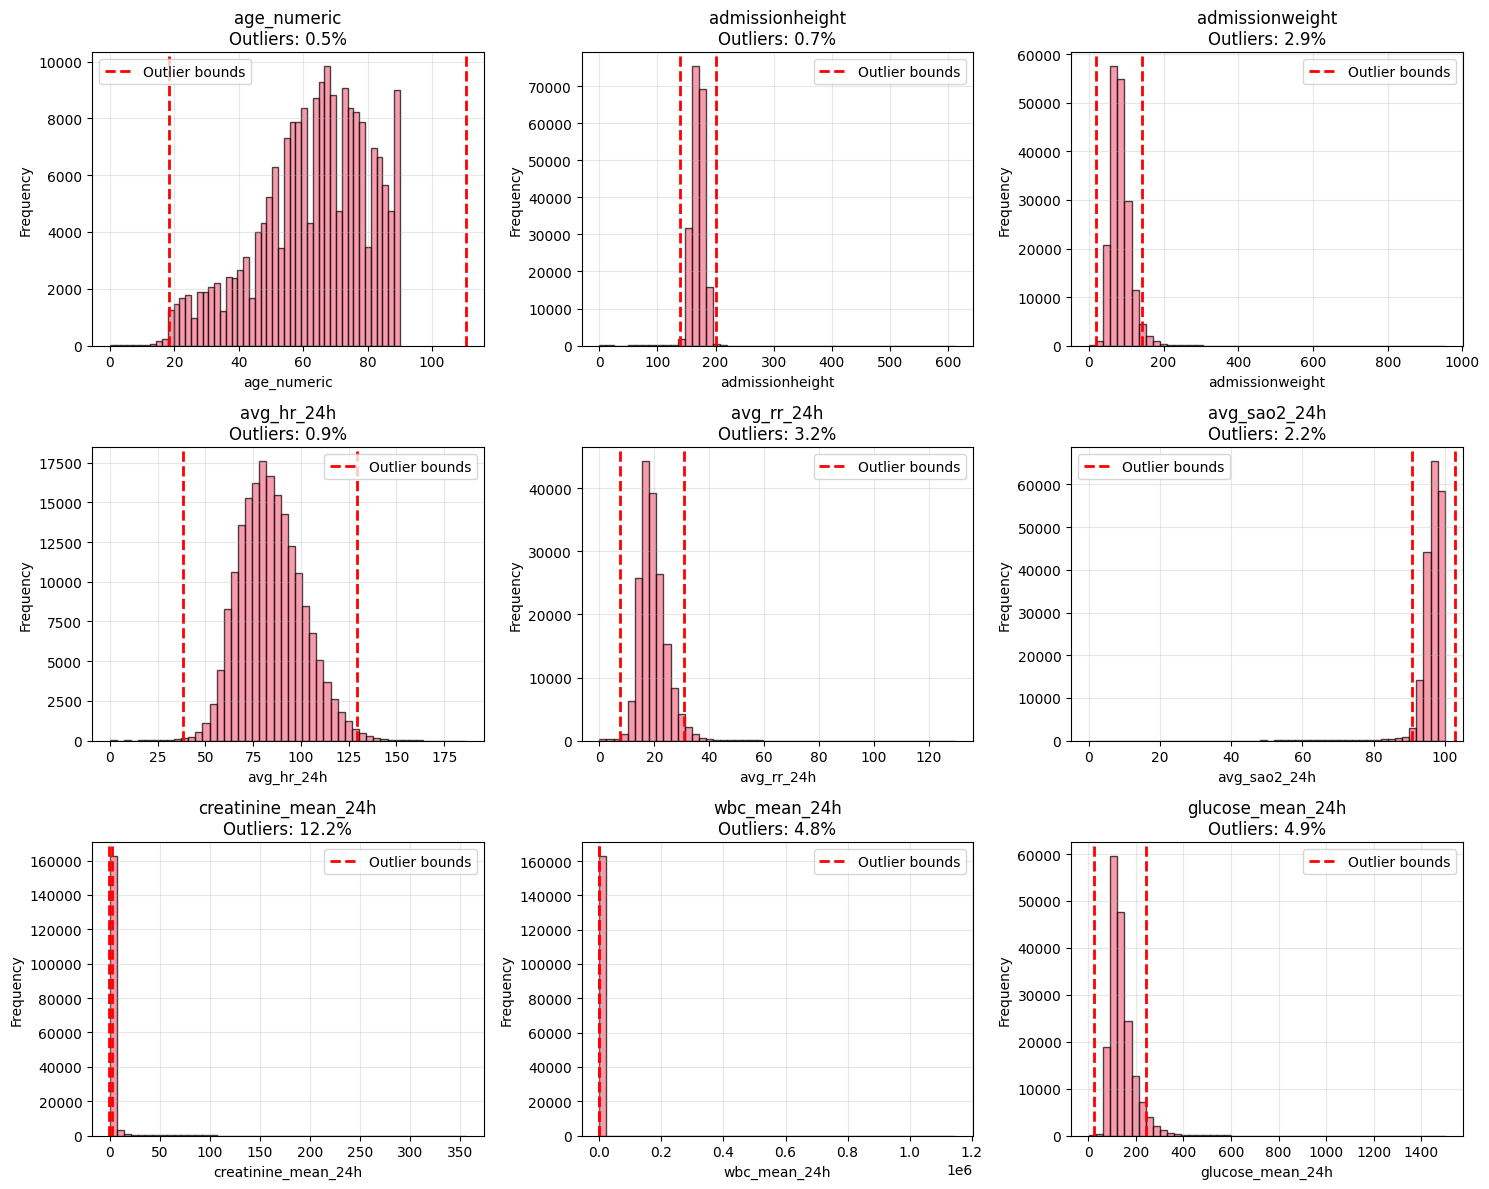

In [9]:
# Visualize distributions with outliers highlighted
n_features = len(key_numeric)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feat in enumerate(key_numeric):
    if feat not in df.columns:
        axes[idx].set_visible(False)
        continue
        
    data = df[feat].dropna()
    
    # Get outlier info
    feat_info = outlier_df[outlier_df['feature'] == feat].iloc[0]
    
    # Plot histogram
    axes[idx].hist(data, bins=50, edgecolor='black', alpha=0.7)
    
    # Add outlier boundaries
    axes[idx].axvline(feat_info['lower_bound'], color='red', linestyle='--', 
                      linewidth=2, label='Outlier bounds')
    axes[idx].axvline(feat_info['upper_bound'], color='red', linestyle='--', linewidth=2)
    
    axes[idx].set_xlabel(feat)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f"{feat}\nOutliers: {feat_info['outlier_pct']:.1f}%")
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(len(key_numeric), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

## 5. Missing Data Patterns

In [10]:
# Comprehensive missing data analysis
missing_summary = pd.DataFrame({
    'feature': df.columns,
    'null_count': df.isnull().sum(),
    'null_pct': (df.isnull().sum() / len(df) * 100).round(2),
    'data_type': df.dtypes
}).sort_values('null_pct', ascending=False).reset_index(drop=True)

missing_features = missing_summary[missing_summary['null_count'] > 0]

print("=" * 80)
print("MISSING DATA SUMMARY")
print("=" * 80)
print(f"\nFeatures with missing values: {len(missing_features)} / {len(df.columns)}")
print(f"\nTop 20 features by missing percentage:")
print(missing_features.head(20).to_string(index=False))

# Check if adding missingness indicators would help
high_missing = missing_features[missing_features['null_pct'] > 30]
if len(high_missing) > 0:
    print(f"\n⚠️  {len(high_missing)} features have >30% missing data")
    print("   Consider adding missingness indicators for these features")
    print(high_missing[['feature', 'null_pct']].to_string(index=False))

MISSING DATA SUMMARY

Features with missing values: 66 / 77

Top 20 features by missing percentage:
                 feature  null_count  null_pct data_type
  apache_electivesurgery      166425     83.36     Int16
        vent_started_24h      154921     77.60     Int32
             ever_vented      154921     77.60     Int32
      pressor_norepi_24h      131917     66.08     Int32
   sedative_propofol_24h      131917     66.08     Int32
        pressor_vaso_24h      131917     66.08     Int32
         pressor_epi_24h      131917     66.08     Int32
     hospitaladmitsource       49118     24.60    object
            wbc_mean_24h       36895     18.48   float64
     creatinine_mean_24h       30033     15.04   float64
      creatinine_max_24h       30033     15.04   float64
         apache_dialysis       29044     14.55     Int16
        apache_urine_24h       29044     14.55   float64
         apache_lymphoma       29044     14.55     Int16
         apache_ventday1       29044     14.5

## 6. Feature Engineering Opportunities

In [11]:
print("=" * 80)
print("FEATURE ENGINEERING OPPORTUNITIES")
print("=" * 80)

# 1. BMI from height and weight
print("\n1. BMI (Body Mass Index)")
has_height = df['admissionheight'].notna().sum()
has_weight = df['admissionweight'].notna().sum()
has_both = (df['admissionheight'].notna() & df['admissionweight'].notna()).sum()
print(f"   Records with height: {has_height:,} ({has_height/len(df)*100:.1f}%)")
print(f"   Records with weight: {has_weight:,} ({has_weight/len(df)*100:.1f}%)")
print(f"   Records with both: {has_both:,} ({has_both/len(df)*100:.1f}%)")
print(f"   ✅ Can create BMI for {has_both:,} records")

# 2. Total GCS score
print("\n2. Total GCS Score (Glasgow Coma Scale)")
has_all_gcs = (
    df['apache_gcs_eyes'].notna() & 
    df['apache_gcs_verbal'].notna() & 
    df['apache_gcs_motor'].notna()
).sum()
print(f"   Records with all GCS components: {has_all_gcs:,} ({has_all_gcs/len(df)*100:.1f}%)")
print(f"   Note: We already have is_missing_gcs_* indicators")
print(f"   ✅ Can create total GCS score for {has_all_gcs:,} records")

# 3. Vital sign ranges
print("\n3. Vital Sign Ranges (max - min)")
vital_pairs = [
    ('avg_hr_24h', 'min_hr_24h', 'max_hr_24h', 'HR range'),
    ('avg_rr_24h', 'min_rr_24h', 'max_rr_24h', 'RR range'),
    ('avg_sao2_24h', 'min_sao2_24h', 'max_sao2_24h', 'SaO2 range'),
]

for avg, min_col, max_col, label in vital_pairs:
    has_range = (df[min_col].notna() & df[max_col].notna()).sum()
    print(f"   {label}: Can create for {has_range:,} records ({has_range/len(df)*100:.1f}%)")

print("\n4. APACHE Score Components")
print("   Note: APACHE scores are already provided in the data")
print("   But we could create interaction features between components")

print("\n5. Hospitalization Context Features")
print("   - ICU readmission flag (apache_readmit already exists)")
print("   - Emergency admission flag (can derive from hospitaladmitsource)")
print("   - Age groups (young, middle, elderly, very elderly)")

FEATURE ENGINEERING OPPORTUNITIES

1. BMI (Body Mass Index)
   Records with height: 195,486 (97.9%)
   Records with weight: 183,514 (91.9%)
   Records with both: 182,123 (91.2%)
   ✅ Can create BMI for 182,123 records

2. Total GCS Score (Glasgow Coma Scale)
   Records with all GCS components: 170,602 (85.5%)
   Note: We already have is_missing_gcs_* indicators
   ✅ Can create total GCS score for 170,602 records

3. Vital Sign Ranges (max - min)
   HR range: Can create for 191,264 records (95.8%)
   RR range: Can create for 176,224 records (88.3%)
   SaO2 range: Can create for 188,402 records (94.4%)

4. APACHE Score Components
   Note: APACHE scores are already provided in the data
   But we could create interaction features between components

5. Hospitalization Context Features
   - ICU readmission flag (apache_readmit already exists)
   - Emergency admission flag (can derive from hospitaladmitsource)
   - Age groups (young, middle, elderly, very elderly)


## 7. Correlation Analysis for Multicollinearity

In [12]:
# Check for highly correlated features (multicollinearity)
numeric_cols = df[current_numeric].select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr().abs()

# Find pairs with correlation > 0.9
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.9:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

print("=" * 80)
print("MULTICOLLINEARITY CHECK (Correlation > 0.9)")
print("=" * 80)

if high_corr_pairs:
    print(f"\nFound {len(high_corr_pairs)} highly correlated feature pairs:")
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: x[2], reverse=True):
        print(f"  {feat1} ↔ {feat2}: {corr:.4f}")
    print("\n⚠️  Consider removing one feature from each highly correlated pair")
else:
    print("\n✅ No highly correlated feature pairs found (correlation > 0.9)")

MULTICOLLINEARITY CHECK (Correlation > 0.9)

Found 7 highly correlated feature pairs:
  apache_vent ↔ apache_ventday1: 1.0000
  is_missing_gcs_eyes ↔ is_missing_gcs_verbal: 1.0000
  is_missing_gcs_eyes ↔ is_missing_gcs_motor: 1.0000
  is_missing_gcs_verbal ↔ is_missing_gcs_motor: 1.0000
  pressor_norepi_24h ↔ pressor_epi_24h: 0.9669
  apache_ph ↔ apache_pco2: 0.9425
  creatinine_mean_24h ↔ creatinine_max_24h: 0.9355

⚠️  Consider removing one feature from each highly correlated pair


## Summary of Findings

Document all findings and recommendations.

In [13]:
print("=" * 80)
print("COMPREHENSIVE FINDINGS & RECOMMENDATIONS")
print("=" * 80)

print("\n📋 1. CATEGORICAL FEATURES")
high_card = cat_df[cat_df['unique_values'] > 20]
if len(high_card) > 0:
    print(f"   ⚠️  {len(high_card)} high-cardinality features found:")
    for _, row in high_card.iterrows():
        print(f"      - {row['feature']}: {row['unique_values']} unique values")
    print("   Recommendation: Consider grouping rare categories or using target encoding")
else:
    print("   ✅ All categorical features have reasonable cardinality")

print("\n📋 2. MISCATEGORIZED FEATURES")
if potential_categorical:
    print(f"   ⚠️  {len(potential_categorical)} features might be categorical:")
    for item in potential_categorical:
        print(f"      - {item['feature']}: {item['unique_values']} unique values")
    print("   Recommendation: Review and reclassify if appropriate")
else:
    print("   ✅ All features are correctly categorized")

print("\n📋 3. APACHE -1.0 VALUES")
features_with_neg = (apache_df['neg_one_count'] > 0).sum()
if features_with_neg > 0:
    print(f"   ⚠️  {features_with_neg} APACHE features have -1.0 values (missing indicators)")
    total_neg_one = apache_df['neg_one_count'].sum()
    print(f"   Total -1.0 values across all features: {total_neg_one:,}")
    print("   🔧 ACTION REQUIRED: Convert -1.0 → NaN for proper imputation")
else:
    print("   ✅ No -1.0 missing indicators found")

print("\n📋 4. OUTLIERS")
high_outlier = outlier_df[outlier_df['outlier_pct'] > 5]
if len(high_outlier) > 0:
    print(f"   ⚠️  {len(high_outlier)} features have >5% outliers:")
    for _, row in high_outlier.iterrows():
        print(f"      - {row['feature']}: {row['outlier_pct']:.1f}% outliers")
    print("   Recommendation: Use RobustScaler instead of StandardScaler")
else:
    print("   ✅ Outlier rates are reasonable (<5%)")

print("\n📋 5. MISSING DATA")
if len(high_missing) > 0:
    print(f"   ⚠️  {len(high_missing)} features have >30% missing:")
    for _, row in high_missing.head(10).iterrows():
        print(f"      - {row['feature']}: {row['null_pct']:.1f}% missing")
    print("   Recommendation: Add missingness indicator features")
else:
    print("   ✅ No features with excessive missing data (>30%)")

print("\n📋 6. FEATURE ENGINEERING")
print("   Recommended new features:")
print(f"      ✅ BMI (Body Mass Index) - {has_both:,} records")
print(f"      ✅ Total GCS Score - {has_all_gcs:,} records")
print("      ✅ Vital sign ranges (HR, RR, SaO2)")
print("      ✅ Age groups (categorical)")
print("      ✅ Emergency admission flag")

print("\n📋 7. MULTICOLLINEARITY")
if high_corr_pairs:
    print(f"   ⚠️  {len(high_corr_pairs)} highly correlated pairs found")
    print("   Recommendation: Consider feature selection or regularization")
else:
    print("   ✅ No severe multicollinearity detected")

print("\n" + "=" * 80)
print("NEXT STEPS: PHASE 2")
print("=" * 80)
print("""
1. Fix APACHE -1.0 values → NaN
2. Reclassify any miscategorized features
3. Implement RobustScaler for features with outliers
4. Add missingness indicators for high-missing features
5. Create engineered features (BMI, total GCS, vital ranges)
6. Update preprocessing pipeline with all improvements
""")
print("=" * 80)

COMPREHENSIVE FINDINGS & RECOMMENDATIONS

📋 1. CATEGORICAL FEATURES
   ✅ All categorical features have reasonable cardinality

📋 2. MISCATEGORIZED FEATURES
   ⚠️  26 features might be categorical:
      - apache_intubated: 2 unique values
      - apache_vent: 2 unique values
      - apache_dialysis: 2 unique values
      - apache_gcs_eyes: 5 unique values
      - apache_gcs_verbal: 6 unique values
      - apache_gcs_motor: 7 unique values
      - apache_admitsource_code: 9 unique values
      - apache_diabetes: 2 unique values
      - apache_aids: 2 unique values
      - apache_hepaticfailure: 2 unique values
      - apache_lymphoma: 2 unique values
      - apache_metastaticcancer: 2 unique values
      - apache_leukemia: 2 unique values
      - apache_immunosuppression: 2 unique values
      - apache_cirrhosis: 2 unique values
      - apache_electivesurgery: 2 unique values
      - apache_readmit: 2 unique values
      - apache_ventday1: 2 unique values
      - apache_oobventday1: 2 u

## Export CSV Samples for Review

Exporting small samples (10-25 records) for each finding to allow manual review.

In [14]:
# Create output directory
output_dir = Path("data_samples")
output_dir.mkdir(exist_ok=True)

print("Output directory:", output_dir.absolute())
print("\nExporting CSV samples for manual review...\n")

Output directory: /home/jamieontiveros/Development/university_michigan/ari510capstone-fedlearn/notebooks/exploratory/data_samples

Exporting CSV samples for manual review...



In [15]:
# EXPORT 1: Categorical Features - Show distribution of top categorical features
print("=" * 80)
print("EXPORT 1: Categorical Features Sample")
print("=" * 80)

# Get 15 random samples with their categorical features
sample_cols = ['patientunitstayid'] + current_categorical
export1 = df[sample_cols].sample(n=15, random_state=42)

export1_path = output_dir / "01_categorical_features_sample.csv"
export1.to_csv(export1_path, index=False)

print(f"Exported {len(export1)} records")
print(f"File: {export1_path}")
print(f"\nSample preview:")
print(export1.head().to_string(index=False))
print("")

EXPORT 1: Categorical Features Sample
Exported 15 records
File: data_samples/01_categorical_features_sample.csv

Sample preview:
 patientunitstayid gender ethnicity     unittype      unitadmitsource  hospitaladmitsource admissiondx_category numbedscategory  teachingstatus hospital_region
            219289 female  Hispanic        CTICU                Floor                Floor          respiratory          >= 500            True         Midwest
            302963   male Caucasian Med-Surg ICU       Operating Room       Operating Room                other          >= 500           False         Midwest
            231014   male Caucasian Med-Surg ICU       Operating Room                 None                other            <100           False         Midwest
            944828 female Caucasian Med-Surg ICU Emergency Department Emergency Department           neurologic            None           False            None
           2828875   male Caucasian    CCU-CTICU Emergency Department  

In [16]:
# EXPORT 2: Miscategorized Features - Binary/low-cardinality features treated as numeric
print("=" * 80)
print("EXPORT 2: Potential Miscategorized Features Sample")
print("=" * 80)

# Show 20 records with binary APACHE flags and other low-cardinality features
misc_features = ['patientunitstayid', 'apache_intubated', 'apache_vent', 'apache_dialysis',
                'apache_diabetes', 'apache_admitsource_code', 'apache_gcs_eyes', 
                'apache_gcs_verbal', 'apache_gcs_motor', 'vent_started_24h', 
                'pressor_norepi_24h', 'pressor_epi_24h']

misc_features = [f for f in misc_features if f in df.columns]
export2 = df[misc_features].sample(n=20, random_state=42)

export2_path = output_dir / "02_miscategorized_features_sample.csv"
export2.to_csv(export2_path, index=False)

print(f"Exported {len(export2)} records")
print(f"File: {export2_path}")
print(f"Features included: {len(misc_features)-1} potential categorical features")
print(f"\nSample preview:")
print(export2.head(10).to_string(index=False))
print("")

EXPORT 2: Potential Miscategorized Features Sample
Exported 20 records
File: data_samples/02_miscategorized_features_sample.csv
Features included: 11 potential categorical features

Sample preview:
 patientunitstayid  apache_intubated  apache_vent  apache_dialysis  apache_diabetes  apache_admitsource_code  apache_gcs_eyes  apache_gcs_verbal  apache_gcs_motor  vent_started_24h  pressor_norepi_24h  pressor_epi_24h
            219289                 1            1                0                0                        4              2.0                1.0               5.0                 0                <NA>             <NA>
            302963                 0            1                0                1                        1              2.0                2.0               4.0              <NA>                   1                1
            231014                 0            0                0                1                        1              4.0                5.0    

In [17]:
# EXPORT 3: APACHE -1.0 Values - Records with missing indicators
print("=" * 80)
print("EXPORT 3: APACHE -1.0 Values Sample")
print("=" * 80)

# Get records with -1.0 values in high-frequency features
high_neg_one_features = ['apache_pao2', 'apache_ph', 'apache_fio2', 'apache_pco2', 
                         'apache_bilirubin', 'apache_albumin']

# Find records with at least one -1.0 value
mask = (df[high_neg_one_features] == -1.0).any(axis=1)
export3_cols = ['patientunitstayid'] + high_neg_one_features
export3 = df[mask][export3_cols].sample(n=min(20, mask.sum()), random_state=42)

export3_path = output_dir / "03_apache_neg_one_values_sample.csv"
export3.to_csv(export3_path, index=False)

print(f"Exported {len(export3)} records with -1.0 values")
print(f"File: {export3_path}")
print(f"\nSample preview (showing -1.0 missing indicators):")
print(export3.head(10).to_string(index=False))
print("")

EXPORT 3: APACHE -1.0 Values Sample
Exported 20 records with -1.0 values
File: data_samples/03_apache_neg_one_values_sample.csv

Sample preview (showing -1.0 missing indicators):
 patientunitstayid  apache_pao2  apache_ph  apache_fio2  apache_pco2  apache_bilirubin  apache_albumin
           1718768         -1.0      -1.00         -1.0         -1.0              -1.0            -1.0
            687826         -1.0      -1.00         -1.0         -1.0               0.9             3.0
            867929         -1.0      -1.00         -1.0         -1.0               0.5             3.6
           2805794         -1.0      -1.00         -1.0         -1.0              -1.0            -1.0
           1481314         -1.0      -1.00         -1.0         -1.0              -1.0            -1.0
            351720         -1.0      -1.00         -1.0         -1.0              -1.0             3.7
            516956         81.9       7.37         24.0         39.4              -1.0            -1

In [18]:
# EXPORT 4: Outliers - Records with outlier values
print("=" * 80)
print("EXPORT 4: Outlier Records Sample")
print("=" * 80)

# Focus on creatinine_mean_24h (12% outliers)
feat_info = outlier_df[outlier_df['feature'] == 'creatinine_mean_24h'].iloc[0]
lower = feat_info['lower_bound']
upper = feat_info['upper_bound']

# Get outlier records
outlier_mask = (df['creatinine_mean_24h'] < lower) | (df['creatinine_mean_24h'] > upper)
outlier_cols = ['patientunitstayid', 'creatinine_mean_24h', 'creatinine_max_24h',
                'apache_creatinine', 'admissionweight', 'age_numeric']

export4 = df[outlier_mask][outlier_cols].sample(n=min(25, outlier_mask.sum()), random_state=42)

export4_path = output_dir / "04_outlier_records_sample.csv"
export4.to_csv(export4_path, index=False)

print(f"Exported {len(export4)} records with outlier creatinine values")
print(f"File: {export4_path}")
print(f"IQR bounds: [{lower:.2f}, {upper:.2f}]")
print(f"\nSample preview:")
print(export4.head(10).to_string(index=False))
print("")

EXPORT 4: Outlier Records Sample
Exported 25 records with outlier creatinine values
File: data_samples/04_outlier_records_sample.csv
IQR bounds: [-0.48, 2.74]

Sample preview:
 patientunitstayid  creatinine_mean_24h  creatinine_max_24h  apache_creatinine  admissionweight  age_numeric
            872305              10.5000               10.50              10.50            96.00           50
            156771               3.4800                3.48              -1.00            64.60           88
           1611207              22.9133              121.20               3.63            74.80           83
            452894               6.1900                6.19               6.19            81.60           85
           2778673               3.7500                3.75               3.75            81.60           42
           1569907              83.1250              163.00               4.13            72.57           79
           3104834              24.0875               91.00  

In [19]:
# EXPORT 5: High Missing Data - Records from features with >30% missing
print("=" * 80)
print("EXPORT 5: High Missing Data Sample")
print("=" * 80)

# Features with >30% missing
high_miss_features = high_missing['feature'].tolist()
export5_cols = ['patientunitstayid'] + high_miss_features

export5 = df[export5_cols].sample(n=20, random_state=42)

export5_path = output_dir / "05_high_missing_data_sample.csv"
export5.to_csv(export5_path, index=False)

print(f"Exported {len(export5)} records")
print(f"File: {export5_path}")
print(f"Features with >30% missing: {len(high_miss_features)}")
print(f"\nSample preview:")
print(export5.head(10).to_string(index=False))
print("\nNote: NaN values represent actual missing data")
print("")

EXPORT 5: High Missing Data Sample
Exported 20 records
File: data_samples/05_high_missing_data_sample.csv
Features with >30% missing: 7

Sample preview:
 patientunitstayid  apache_electivesurgery  vent_started_24h  ever_vented  pressor_norepi_24h  sedative_propofol_24h  pressor_vaso_24h  pressor_epi_24h
            219289                    <NA>                 0            1                <NA>                   <NA>              <NA>             <NA>
            302963                       1              <NA>         <NA>                   1                      0                 1                1
            231014                       0              <NA>         <NA>                <NA>                   <NA>              <NA>             <NA>
            944828                    <NA>                 1            1                   0                      1                 0                0
           2828875                    <NA>              <NA>         <NA>              

In [20]:
# EXPORT 6: Feature Engineering Candidates - Records where we can create new features
print("=" * 80)
print("EXPORT 6: Feature Engineering Candidates Sample")
print("=" * 80)

# Get records where we can create BMI, total GCS, and vital ranges
has_bmi_data = df['admissionheight'].notna() & df['admissionweight'].notna()
has_gcs_data = (df['apache_gcs_eyes'].notna() & 
                df['apache_gcs_verbal'].notna() & 
                df['apache_gcs_motor'].notna())
has_vitals = df['min_hr_24h'].notna() & df['max_hr_24h'].notna()

# Get records with all engineerable features
mask = has_bmi_data & has_gcs_data & has_vitals

eng_cols = ['patientunitstayid', 'admissionheight', 'admissionweight',
            'apache_gcs_eyes', 'apache_gcs_verbal', 'apache_gcs_motor',
            'min_hr_24h', 'max_hr_24h', 'min_rr_24h', 'max_rr_24h',
            'min_sao2_24h', 'max_sao2_24h']

export6 = df[mask][eng_cols].sample(n=min(20, mask.sum()), random_state=42)

# Calculate the engineered features for demonstration
export6 = export6.copy()
export6['BMI'] = export6['admissionweight'] / ((export6['admissionheight']/100) ** 2)
export6['total_GCS'] = (export6['apache_gcs_eyes'] + 
                        export6['apache_gcs_verbal'] + 
                        export6['apache_gcs_motor'])
export6['HR_range'] = export6['max_hr_24h'] - export6['min_hr_24h']

export6_path = output_dir / "06_feature_engineering_sample.csv"
export6.to_csv(export6_path, index=False)

print(f"Exported {len(export6)} records with engineerable features")
print(f"File: {export6_path}")
print(f"\nNew features demonstrated: BMI, total_GCS, HR_range")
print(f"\nSample preview:")
print(export6[['patientunitstayid', 'admissionheight', 'admissionweight', 'BMI', 
               'apache_gcs_eyes', 'apache_gcs_verbal', 'apache_gcs_motor', 'total_GCS']].head(10).to_string(index=False))
print("")

EXPORT 6: Feature Engineering Candidates Sample
Exported 20 records with engineerable features
File: data_samples/06_feature_engineering_sample.csv

New features demonstrated: BMI, total_GCS, HR_range

Sample preview:
 patientunitstayid  admissionheight  admissionweight     BMI  apache_gcs_eyes  apache_gcs_verbal  apache_gcs_motor  total_GCS
            230623            149.9            56.50 25.1446              4.0                5.0               6.0       15.0
           3170667            172.0            68.00 22.9854              4.0                5.0               6.0       15.0
           1602969            157.0            79.00 32.0500              4.0                5.0               6.0       15.0
            222641            190.5            98.70 27.1974              4.0                5.0               6.0       15.0
            581799            187.0           109.00 31.1705              3.0                2.0               6.0       11.0
           1566687        

In [21]:
# EXPORT 7: Multicollinearity - Show highly correlated feature pairs
print("=" * 80)
print("EXPORT 7: Multicollinearity Sample")
print("=" * 80)

# Create a dataframe showing the correlated pairs
corr_data = []
for feat1, feat2, corr_val in high_corr_pairs:
    # Get sample values for both features
    sample_records = df[[feat1, feat2]].dropna().sample(n=min(5, len(df)), random_state=42)
    for idx, row in sample_records.iterrows():
        corr_data.append({
            'feature_1': feat1,
            'feature_2': feat2,
            'correlation': corr_val,
            'value_1': row[feat1],
            'value_2': row[feat2]
        })

export7 = pd.DataFrame(corr_data)

export7_path = output_dir / "07_multicollinearity_sample.csv"
export7.to_csv(export7_path, index=False)

print(f"Exported {len(export7)} sample records showing correlated pairs")
print(f"File: {export7_path}")
print(f"\nHighly correlated pairs (correlation > 0.9):")
for feat1, feat2, corr_val in sorted(high_corr_pairs, key=lambda x: x[2], reverse=True):
    print(f"  {feat1} ↔ {feat2}: {corr_val:.4f}")
print(f"\nSample preview:")
print(export7.head(15).to_string(index=False))
print("")

EXPORT 7: Multicollinearity Sample
Exported 35 sample records showing correlated pairs
File: data_samples/07_multicollinearity_sample.csv

Highly correlated pairs (correlation > 0.9):
  apache_vent ↔ apache_ventday1: 1.0000
  is_missing_gcs_eyes ↔ is_missing_gcs_verbal: 1.0000
  is_missing_gcs_eyes ↔ is_missing_gcs_motor: 1.0000
  is_missing_gcs_verbal ↔ is_missing_gcs_motor: 1.0000
  pressor_norepi_24h ↔ pressor_epi_24h: 0.9669
  apache_ph ↔ apache_pco2: 0.9425
  creatinine_mean_24h ↔ creatinine_max_24h: 0.9355

Sample preview:
          feature_1             feature_2  correlation  value_1  value_2
        apache_vent       apache_ventday1       1.0000      0.0      0.0
        apache_vent       apache_ventday1       1.0000      0.0      0.0
        apache_vent       apache_ventday1       1.0000      0.0      0.0
        apache_vent       apache_ventday1       1.0000      0.0      0.0
        apache_vent       apache_ventday1       1.0000      1.0      1.0
          apache_ph        

In [22]:
# Summary of all exports
print("=" * 80)
print("EXPORT SUMMARY")
print("=" * 80)
print(f"\nAll CSV files saved to: {output_dir.absolute()}")
print(f"\nExported files:")
for csv_file in sorted(output_dir.glob("*.csv")):
    size_kb = csv_file.stat().st_size / 1024
    print(f"  - {csv_file.name} ({size_kb:.1f} KB)")
print(f"\n✅ All exports completed successfully!")
print("=" * 80)

EXPORT SUMMARY

All CSV files saved to: /home/jamieontiveros/Development/university_michigan/ari510capstone-fedlearn/notebooks/exploratory/data_samples

Exported files:
  - 01_categorical_features_sample.csv (1.4 KB)
  - 02_miscategorized_features_sample.csv (0.9 KB)
  - 03_apache_neg_one_values_sample.csv (0.8 KB)
  - 04_outlier_records_sample.csv (0.9 KB)
  - 05_high_missing_data_sample.csv (0.5 KB)
  - 06_feature_engineering_sample.csv (1.7 KB)
  - 07_multicollinearity_sample.csv (1.9 KB)

✅ All exports completed successfully!
